In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf
from scipy.stats import boxcox
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX as sarimax
from itertools import product

In [2]:
def read_data():
    ts = pd.read_csv('data/debitcards.csv', index_col=0, parse_dates=True)
    ts.index.freq = "MS"
    index = ts.index
    return ts, index

ts, index = read_data()
ts

V1
2000-01-01   7204.0
2000-02-01   7335.0
2000-03-01   7812.0
2000-04-01   7413.0
2000-05-01   9136.0
...             ...
2012-08-01  24920.0
2012-09-01  20325.0
2012-10-01  22038.0
2012-11-01  20988.0
2012-12-01  26675.0

[156 rows x 1 columns]

In [3]:
def split(data):
    train = data[:"2006-01-01"] 
    test = data["2006-01-01":]
    return train, test

ts_train, ts_test = split(ts)

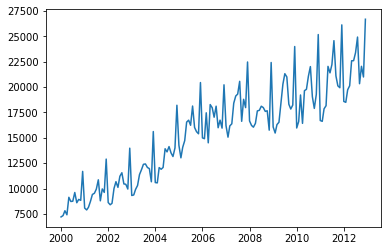

In [4]:
def plot_data(data):
    plt.plot(data)
    plt.show()

plot_data(ts)

In [5]:
def is_stationnary(data):
    test = adfuller(data)
    pvalue = test[1]
    if pvalue < 0.05:
        return True
    return False

The time-series is obviously not stationnary

In [6]:
def plot_acf_pacf(data):
    fig, ax = plt.subplots(2, figsize=(8,4))
    plot_acf(data, ax=ax[0])
    plot_pacf(data, ax=ax[1])
    plt.show()

In [7]:
def perform_boxcox(data, index):
    reg = boxcox(data)[0]
    reg = pd.DataFrame(reg, index=index, columns=['V1'])
    return reg

In [8]:
def perform_diff(data, d):
    diff = data.diff(d)
    return diff

In [9]:
#reg = perform_boxcox(ts.V1, index)
#diff = perform_diff(reg, 1)
#diff = diff.dropna()
#plt.plot(diff)
#plot_acf_pacf(diff)
#is_stationnary(diff)

Do not seem to work

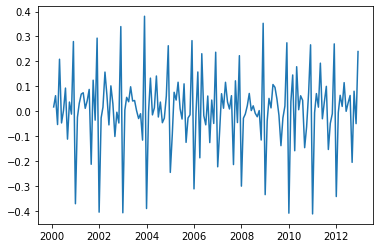

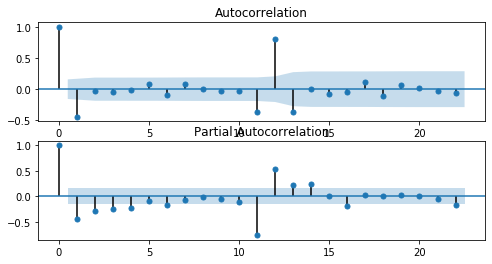

In [10]:
reg = np.log(ts.V1)
diff = perform_diff(reg, 1)
diff = diff.dropna()
plt.plot(diff)
diff
plot_acf_pacf(diff)

In [11]:
def arima(data, p, d, q):
    arima = sarimax(data, order=(p,d,q))
    fit = arima.fit()
    #fit.plot_diagnostics()
    #plt.show()
    #print(fit.summary())
    return arima

arima_fit = arima(ts_train, 3, 1, 0).fit()
arima_test = arima(ts, 3, 1, 0)

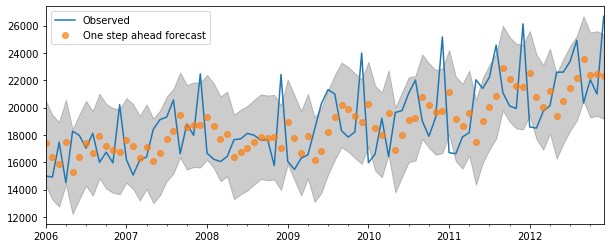

In [12]:
def predict(model_fit, model_test):
    model_test_res = model_test.filter(model_fit.params)
    pred = model_test_res.get_prediction(start="2006-01-01")
    pred_ci = pred.conf_int()
    ax = ts_test.plot(y="V1", label="Observed", figsize=(10, 4))
    pred.predicted_mean.plot(ax=ax, 
                             label="One step ahead forecast", 
                             alpha=0.7, 
                             linestyle='',
                             marker='o')
    ax.fill_between(pred_ci.index, 
                    pred_ci['lower V1'], 
                    pred_ci['upper V1'], 
                    color="k",
                    alpha=0.2)
    plt.legend()

predict(arima_fit, arima_test)

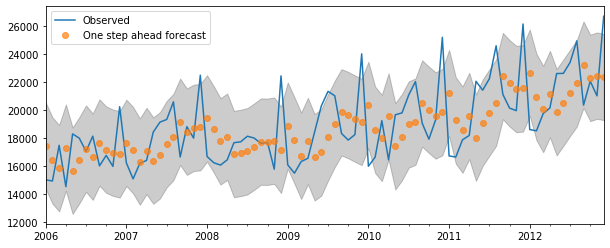

In [13]:
model = sarimax(ts_train, order=(4,1,1))
model_fit = model.fit()
model_test = sarimax(ts, order=(4,1,1))
model_test_res = model_test.filter(model_fit.params)
pred = model_test_res.get_prediction(start='2006-01-01')
pred_ci = pred.conf_int()
ax = ts_test.plot(y='V1', label='Observed', figsize=(10,4))
pred.predicted_mean.plot(ax=ax, label="One step ahead forecast", alpha=0.7, linestyle='', marker='o')
ax.fill_between(pred_ci.index, pred_ci['lower V1'], pred_ci['upper V1'], color='k', alpha=0.2)
plt.legend()

In [14]:
def optimize_ARIMA(order_list, data):
    results = []
    
    for order in order_list:
        try: 
            model = sarimax(data, order=order).fit(disp=-1)
        except:
            continue
            
        results.append([order, model.aic, model.bic, model.mse])
        
    result_df = pd.DataFrame(results, columns=['(p, d, q)', 'AIC', 'BIC', 'MSE'])
    #Sort in ascending order, lower AIC is better
    result_df = result_df.sort_values(by='BIC', ascending=True).reset_index(drop=True)
    
    return result_df

ps = range(0, 8, 1)
d = 1
qs = range(0, 8, 1)# Create a list with all possible combination of parameters
parameters = product(ps, qs)
parameters_list = list(parameters)
order_list = []
for each in parameters_list:
    each = list(each)
    each.insert(1, 1)
    each = tuple(each)
    order_list.append(each)
#order_list
    
result_df = optimize_ARIMA(order_list, ts)
result_df

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)
/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals

(p, d, q)          AIC          BIC           MSE
0   (6, 1, 6)  2772.679719  2812.244245  2.980010e+06
1   (0, 1, 1)  2807.718575  2813.805425  4.512559e+06
2   (3, 1, 5)  2787.655523  2815.046349  3.640115e+06
3   (1, 1, 3)  2800.591737  2815.808862  4.140381e+06
4   (3, 1, 4)  2791.848334  2816.195735  3.747772e+06
..        ...          ...          ...           ...
59  (7, 1, 2)  2820.880791  2851.315042  4.434950e+06
60  (7, 1, 5)  2815.184719  2854.749246  3.277005e+06
61  (6, 1, 5)  2823.783539  2860.304640  3.503783e+06
62  (7, 1, 4)  2833.246096  2869.767197  3.562849e+06
63  (0, 1, 0)  2868.739833  2871.783258  6.599418e+06

[64 rows x 4 columns]

In [15]:
best_model = sarimax(ts, order=(6,1,6)).fit()
print(best_model.summary())

/usr/local/lib/python3.7/site-packages/statsmodels/tsa/statespace/sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                               SARIMAX Results                                
Dep. Variable:                     V1   No. Observations:                  156
Model:               SARIMAX(6, 1, 6)   Log Likelihood               -1373.340
Date:                Tue, 10 Nov 2020   AIC                           2772.680
Time:                        18:02:17   BIC                           2812.244
Sample:                    01-01-2000   HQIC                          2788.750
                         - 12-01-2012                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.7309      0.111     -6.613      0.000      -0.948      -0.514
ar.L2         -1.0617      0.171     -6.199      0.000      -1.397      -0.726
ar.L3         -1.2718      0.108    -11.735      0.0

/usr/local/lib/python3.7/site-packages/statsmodels/base/model.py:568: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  ConvergenceWarning)


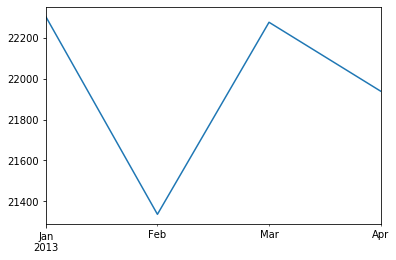

In [26]:
forecast = best_model.forecast(steps=4, exog=ts_test)
forecast.plot()
plt.show()